<a href="https://colab.research.google.com/github/muhmmadzs/Autoencoder/blob/main/Class_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook contain the example of application of  autoencoder for bridge damage detection. **

For question and queries Contact:muhammad.z.sarwar@ntnu.no


> For runing on **COLAB** run the following cell.







In [22]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This cell contain the script to import all the required libraries and function 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation, Dropout, Dense,Conv1DTranspose,Concatenate,Input,Conv1D,MaxPooling1D,Flatten,UpSampling1D,Reshape
from tensorflow.keras.models import load_model,Model
from tensorflow.keras import backend as K

Make sure that your notebook is able access available GPU.
If not follow these steps
* Go to the tab and select Runtime
* In Runtime select "Change Runtime type"
* In Dialogue box Change "Hardware accelerator" to GPU


In [24]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

#Loading dataset for training. 
The training dataset contain the accleration response from Single degree of freedom system (Vehicle) traversing the bridge as shown in Figure Ref [[1]](https://www.sciencedirect.com/science/article/pii/S0022460X04005863). For each crossing event variation in vehicle speed and mass is introduced.
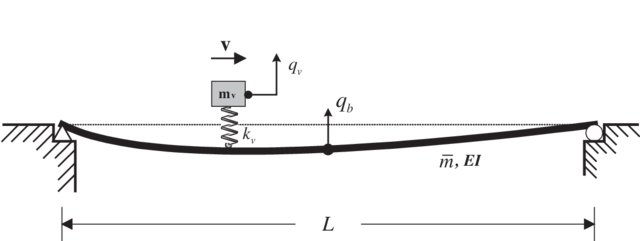

Download Dataset folder by clicking here [link](
https://drive.google.com/drive/folders/1M4gXVAAOhidvDCI1xnWdVGNDQJ93Sv3M?usp=sharing).
Data-Set inlcudes:

* 1000 Vehicle crossing for healthy Bridge (Used for training)
* 1000 Vehicle crossing for healthy Bridge.       :DC0
* 1000 Vehicle crossing for 15% damage at midspan :DC1
* 1000 Vehicle crossing for 30% damage at midspan :DC2




In [25]:
#Loading Training Data_Set
mat = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Healthy.mat')
X_data = mat['input_train']
print(np.shape(X_data))

(1000, 1500)



# Normalised the data set with zero mean and unit varaince 

In [26]:
# Standarization of Training Data Set 
X_data = np.reshape(X_data, [X_data.shape[0], X_data.shape[1], 1])
X_data_flatten = np.reshape(X_data, [X_data.shape[0]*X_data.shape[1], X_data.shape[2]])
scaler_X = StandardScaler()
scaler_X.fit(X_data_flatten)
X_data_flatten_map = scaler_X.transform(X_data_flatten)
X_data_map = np.reshape(X_data_flatten_map, [X_data.shape[0], X_data.shape[1], X_data.shape[2]])
print(np.shape(X_data_map))


(1000, 1500, 1)


# Split the data into training and validation 

In [27]:
# Dividing Data_Set into Training and Validation

N=700;
# Input for Conv_AE model
X_train = X_data_map[0:N]
X_vali  = X_data_map[N:]
print(np.shape(X_train))
print(np.shape(X_vali))

# input for basic AE model
X_train_dense=X_train[:,:,-1]
X_vali_dense=X_vali[:,:,-1]

print(np.shape(X_train_dense))


(700, 1500, 1)
(300, 1500, 1)
(700, 1500)


In [28]:
data_dim = X_train.shape[2]
timesteps = X_train.shape[1]
print(data_dim, timesteps)

1 1500


#Architecture of Simple Autoencoder model


In [29]:
# Build Autoencoder model using basic layers.
input_sig = Input(shape=(timesteps,))
encoded = Dense(128, activation='relu')(input_sig)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(timesteps, activation='linear')(decoded)

AE = Model(input_sig, decoded) 
encoder=Model(input_sig,encoded)

AE.summary()




Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1500)]            0         
                                                                 
 dense_13 (Dense)            (None, 128)               192128    
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 32)                544       
                                                                 
 dense_18 (Dense)            (None, 64)                2112

Compile and train the AE model

In [30]:
# Compile the Model and Start Training 
adam = Adam(lr=0.001, decay=0.0001)
AE.compile(loss='mean_squared_error',    # categorical_crossentropy, mean_squared_error, mean_absolute_error
              optimizer=adam,               
              metrics=['mse'])
epochs=5
batch_size=64
AE.fit(X_train_dense, X_train_dense,
          batch_size=batch_size,
          validation_data=(X_vali_dense, X_vali_dense),
          shuffle=True,
          epochs=epochs
          )

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - 1s 31ms/step - loss: 0.8413 - mse: 0.8413 - val_loss: 0.5326 - val_mse: 0.5326
Epoch 2/5
11/11 [==============================] - 0s 6ms/step - loss: 0.3804 - mse: 0.3804 - val_loss: 0.2072 - val_mse: 0.2072
Epoch 3/5
11/11 [==============================] - 0s 6ms/step - loss: 0.1649 - mse: 0.1649 - val_loss: 0.0797 - val_mse: 0.0797
Epoch 4/5
11/11 [==============================] - 0s 6ms/step - loss: 0.0713 - mse: 0.0713 - val_loss: 0.0398 - val_mse: 0.0398
Epoch 5/5
11/11 [==============================] - 0s 6ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.0235 - val_mse: 0.0235


Plotting for AE autonencoder

5/5 [==============================] - 0s 2ms/step


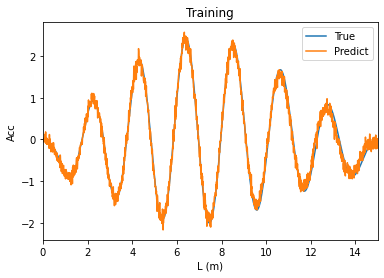

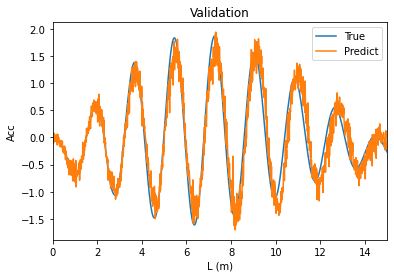

In [31]:
# plotting Training and testing data 
X_train_Pred_dense=AE.predict(X_train_dense,batch_size=batch_size)
X_vali_Pred_dense=AE.predict(X_vali_dense,batch_size=batch_size)
dist=np.linspace(0, 15, num=1500)
for sample in range(1):
    plt.figure()
    plt.plot(dist,X_train_dense[sample,:], label='True')
    plt.plot(dist,X_train_Pred_dense[sample,:], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('Training')
    plt.legend()

for sample in range(1):
    plt.figure()
    plt.plot(dist,X_vali_dense[sample,:], label='True')
    plt.plot(dist,X_vali_Pred_dense[sample,:], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('Validation')
    plt.legend()

Testing on New datasets

In [32]:
# Loading Data for Damage Evaluation and Testing & Setting the scale.
mat00 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage00.mat')
X_Dam_00 = mat00['input_test']
mat15 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage15.mat')
X_Dam_15 = mat15['input_test']
mat30 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage30.mat')
X_Dam_30 = mat30['input_test']

# Scaling for DC0
X_Dam_00 = np.reshape(X_Dam_00, [X_Dam_00.shape[0], X_Dam_00.shape[1], 1])
X_Dam_00_flatten = np.reshape(X_Dam_00, [X_Dam_00.shape[0]*X_Dam_00.shape[1], X_Dam_00.shape[2]])
X_Dam_00_flatten_map = scaler_X.transform(X_Dam_00_flatten)
X_Dam_00_map = np.reshape(X_Dam_00_flatten_map, [X_Dam_00.shape[0], X_Dam_00.shape[1], X_Dam_00.shape[2]])
X_Dam_00_dense=X_Dam_00[:,:,-1]
X_Dam_00_map_dense=X_Dam_00_map[:,:,-1]

# Scaling for DC1

X_Dam_15 = np.reshape(X_Dam_15, [X_Dam_15.shape[0], X_Dam_15.shape[1], 1])
X_Dam_15_flatten = np.reshape(X_Dam_15, [X_Dam_15.shape[0]*X_Dam_15.shape[1], X_Dam_15.shape[2]])
X_Dam_15_flatten_map = scaler_X.transform(X_Dam_15_flatten)
X_Dam_15_map = np.reshape(X_Dam_15_flatten_map, [X_Dam_15.shape[0], X_Dam_15.shape[1], X_Dam_15.shape[2]])
X_Dam_15_dense=X_Dam_15[:,:,-1]
X_Dam_15_map_dense=X_Dam_15_map[:,:,-1]
# Scaling for DC2
X_Dam_30 = np.reshape(X_Dam_30, [X_Dam_30.shape[0], X_Dam_30.shape[1], 1])
X_Dam_30_flatten = np.reshape(X_Dam_30, [X_Dam_30.shape[0]*X_Dam_30.shape[1], X_Dam_30.shape[2]])
X_Dam_30_flatten_map = scaler_X.transform(X_Dam_30_flatten)
X_Dam_30_map = np.reshape(X_Dam_30_flatten_map, [X_Dam_30.shape[0], X_Dam_30.shape[1], X_Dam_30.shape[2]])
X_Dam_30_dense=X_Dam_30[:,:,-1]
X_Dam_30_map_dense=X_Dam_30_map[:,:,-1]

16/16 [==============================] - 0s 2ms/step


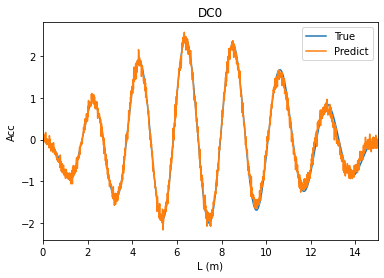

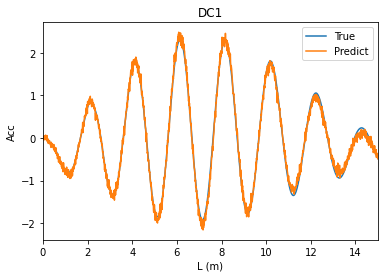

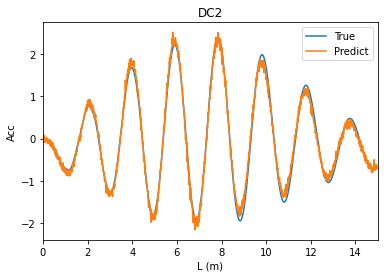

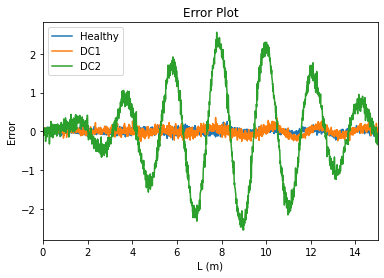

In [33]:
# plotting Training and testing data 
X_Dam_00_Pred_dense=AE.predict(X_Dam_00_map_dense,batch_size=batch_size)
X_Dam_15_Pred_dense=AE.predict(X_Dam_15_map_dense,batch_size=batch_size)
X_Dam_30_Pred_dense=AE.predict(X_Dam_30_map_dense,batch_size=batch_size)



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_00_map_dense[sample,:], label='True')
    plt.plot(dist,X_Dam_00_Pred_dense[sample,:], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC0')
    plt.legend()



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_15_map_dense[sample,:], label='True')
    plt.plot(dist,X_Dam_15_Pred_dense[sample,:], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC1')
    plt.legend()



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_30_map_dense[sample,:], label='True')
    plt.plot(dist,X_Dam_30_Pred_dense[sample,:], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC2')
    plt.legend()

plt.figure()
plt.plot(dist,X_Dam_00_map_dense[2,:]-X_Dam_00_Pred_dense[2,:],label='Healthy')
plt.plot(dist,X_Dam_15_map_dense[2,:]-X_Dam_15_Pred_dense[2,:],label='DC1')
plt.plot(dist,X_Dam_15_map_dense[2,:]-X_Dam_30_Pred_dense[2,:],label='DC2')
plt.xlim(0,15)
plt.xlabel('L (m)')
plt.ylabel('Error')
plt.title('Error Plot')
plt.legend()

#Architecture of Convolutional Autoencoder model


In [34]:
# Build Convlutional Autoencoder model.
input_sig = Input(shape=(timesteps,data_dim)) 


Encoder = Conv1D(64,3,activation='relu', padding='same')(input_sig)    
Encoder = MaxPooling1D(3)(Encoder) 

Encoder = Conv1D(32,3,activation='relu', padding='same')(Encoder)   
Encoder = MaxPooling1D(2)(Encoder) 

Encoder = Conv1D(16,3, activation='relu', padding='same')(Encoder)    
Encoder = MaxPooling1D(2)(Encoder) 

Encoder = Conv1D(8,3, activation='relu', padding='same')(Encoder)   




flat = Flatten()(Encoder) 


encoded = Dense(16,activation = 'linear',kernel_regularizer=tf.keras.regularizers.l1(1e-4))(flat) 

Decoder =  Dense(1000,activation = 'relu')(encoded) 
Decoder =  Reshape((125,8))(Decoder)

Decoder = Conv1D(8, 3,activation='relu', padding='same')(Decoder) 

Decoder = UpSampling1D(2)(Decoder) 
Decoder = Conv1D(16, 3,activation='relu', padding='same')(Decoder) 


Decoder = UpSampling1D(2)(Decoder) 
Decoder = Conv1D(32, 3,activation='relu', padding='same')(Decoder) 

Decoder = UpSampling1D(3)(Decoder) 
Decoder = Conv1D(64, 3,activation='relu', padding='same')(Decoder) 



decoded = Conv1D(data_dim,1, padding='same', activation = 'linear')(Decoder) 


Conv_AE = Model(input_sig, decoded) 
encoder=Model(input_sig,encoded)

Conv_AE.summary()





Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1500, 1)]         0         
                                                                 
 conv1d_18 (Conv1D)          (None, 1500, 64)          256       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 500, 64)          0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, 500, 32)           6176      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 250, 32)          0         
 1D)                                                             
                                                                 
 conv1d_20 (Conv1D)          (None, 250, 16)           1552

In [58]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Generate a simple time series dataset


# Build the VAE model
encoder_inputs = keras.layers.Input(shape=(timesteps, 1))
encoded = keras.layers.Conv1D(32, 3, activation="relu", strides=2)(encoder_inputs)
encoded = keras.layers.Conv1D(64, 3, activation="relu", strides=2)(encoded)
encoded = keras.layers.Flatten()(encoded)
z_mean = keras.layers.Dense(32, name="z_mean")(encoded)
z_log_var = keras.layers.Dense(32, name="z_log_var")(encoded)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], 32))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = keras.layers.Lambda(sampling, output_shape=(32,), name="z")([z_mean, z_log_var])

decoder_inputs = keras.layers.Input(shape=(32,))
decoded = keras.layers.Dense(64 * int((timesteps ) / 4), activation="relu")(z)
decoded = keras.layers.Reshape((int((timesteps ) / 4), 64))(decoded)
decoded = keras.layers.Conv1DTranspose(64, 3, activation="relu", strides=2, padding="same")(decoded)
decoded = keras.layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(decoded)
decoder_outputs = keras.layers.Conv1D(1, 1, activation="linear", padding="same")(decoded)


encoder=keras.models.Model(encoder_inputs, z, name="encoder")

vae = keras.models.Model(encoder_inputs, decoder_outputs, name="vae")

# Define the VAE loss function
def vae_loss(encoder_inputs, decoder_outputs):
    reconstruction_loss = tf.keras.backend.mean(keras.losses.mean_squared_error(encoder_inputs, decoder_outputs))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss
vae.add_loss(vae_loss(encoder_inputs, decoder_outputs))
vae.summary()
# Compile the VAE model





Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 1500, 1)]    0           []                               
                                                                                                  
 conv1d_51 (Conv1D)             (None, 749, 32)      128         ['input_27[0][0]']               
                                                                                                  
 conv1d_52 (Conv1D)             (None, 374, 64)      6208        ['conv1d_51[0][0]']              
                                                                                                  
 flatten_13 (Flatten)           (None, 23936)        0           ['conv1d_52[0][0]']              
                                                                                                

In [59]:
# Compile the Model and Start Training 
adam = Adam(lr=0.001, decay=0.0001)
vae.compile( optimizer=adam, 
            metrics=['mse']              
              )
epochs=1000
batch_size=32
vae.fit(X_train, X_train,
          batch_size=batch_size,
          validation_data=(X_vali, X_vali),
          shuffle=True,
          epochs=epochs
          )

Epoch 1/1000


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/22 [==============================] - 1s 23ms/step - loss: 1.0296 - mse: 0.9599 - val_loss: 0.8510 - val_mse: 0.8455
Epoch 2/1000
22/22 [==============================] - 0s 12ms/step - loss: 0.5986 - mse: 0.5377 - val_loss: 0.3267 - val_mse: 0.1941
Epoch 3/1000
22/22 [==============================] - 0s 11ms/step - loss: 0.2890 - mse: 0.1785 - val_loss: 0.2469 - val_mse: 0.1481
Epoch 4/1000
22/22 [==============================] - 0s 9ms/step - loss: 0.2505 - mse: 0.1415 - val_loss: 0.2285 - val_mse: 0.1081
Epoch 5/1000
22/22 [==============================] - 0s 9ms/step - loss: 0.2315 - mse: 0.1201 - val_loss: 0.2141 - val_mse: 0.1056
Epoch 6/1000
22/22 [==============================] - 0s 9ms/step - loss: 0.2060 - mse: 0.0973 - val_loss: 0.1969 - val_mse: 0.1007
Epoch 7/1000
22/22 [==============================] - 0s 9ms/step - loss: 0.1904 - mse: 0.0879 - val_loss: 0.1847 - val_mse: 0.0752
Epoch 8/1000
22/22 [==============================] - 0s 11ms/step - loss: 0.1788 - ms

 Plotting 

10/10 [==============================] - 0s 4ms/step


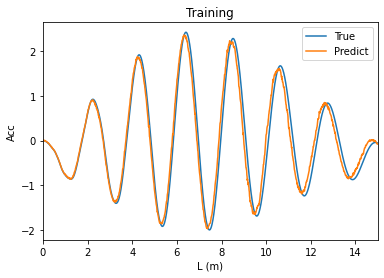

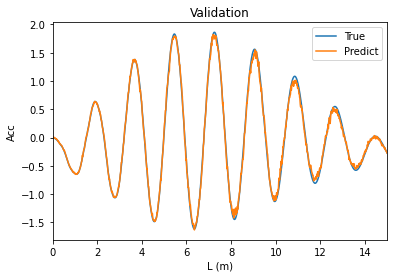

In [60]:
# plotting Training and testing data 
X_train_Pred=vae.predict(X_train,batch_size=batch_size)
X_vali_Pred=vae.predict(X_vali,batch_size=batch_size)
dist=np.linspace(0, 15, num=1500)
for sample in range(1):
    plt.figure()
    plt.plot(dist,X_train[sample,:], label='True')
    plt.plot(dist,X_train_Pred[sample][:, 0], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('Training')
    plt.legend()

for sample in range(1):
    plt.figure()
    plt.plot(dist,X_vali[sample,:], label='True')
    plt.plot(dist,X_vali_Pred[sample][:, 0], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('Validation')
    plt.legend()


Testing on New dataset

In [61]:
# Loading Data for Damage Evaluation and Testing & Setting the scale.
mat00 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage00.mat')
X_Dam_00 = mat00['input_test']
mat15 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage15.mat')
X_Dam_15 = mat15['input_test']
mat30 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage30.mat')
X_Dam_30 = mat30['input_test']

# Scaling for DC0
X_Dam_00 = np.reshape(X_Dam_00, [X_Dam_00.shape[0], X_Dam_00.shape[1], 1])
X_Dam_00_flatten = np.reshape(X_Dam_00, [X_Dam_00.shape[0]*X_Dam_00.shape[1], X_Dam_00.shape[2]])
X_Dam_00_flatten_map = scaler_X.transform(X_Dam_00_flatten)
X_Dam_00_map = np.reshape(X_Dam_00_flatten_map, [X_Dam_00.shape[0], X_Dam_00.shape[1], X_Dam_00.shape[2]])
X_Dam_00_Dense=X_Dam_00[:,:,-1]
# Scaling for DC1

X_Dam_15 = np.reshape(X_Dam_15, [X_Dam_15.shape[0], X_Dam_15.shape[1], 1])
X_Dam_15_flatten = np.reshape(X_Dam_15, [X_Dam_15.shape[0]*X_Dam_15.shape[1], X_Dam_15.shape[2]])
X_Dam_15_flatten_map = scaler_X.transform(X_Dam_15_flatten)
X_Dam_15_map = np.reshape(X_Dam_15_flatten_map, [X_Dam_15.shape[0], X_Dam_15.shape[1], X_Dam_15.shape[2]])
X_Dam_15_Dense=X_Dam_15[:,:,-1]

# Scaling for DC2
X_Dam_30 = np.reshape(X_Dam_30, [X_Dam_30.shape[0], X_Dam_30.shape[1], 1])
X_Dam_30_flatten = np.reshape(X_Dam_30, [X_Dam_30.shape[0]*X_Dam_30.shape[1], X_Dam_30.shape[2]])
X_Dam_30_flatten_map = scaler_X.transform(X_Dam_30_flatten)
X_Dam_30_map = np.reshape(X_Dam_30_flatten_map, [X_Dam_30.shape[0], X_Dam_30.shape[1], X_Dam_30.shape[2]])
X_Dam_30_Dense=X_Dam_30[:,:,-1]

32/32 [==============================] - 0s 3ms/step


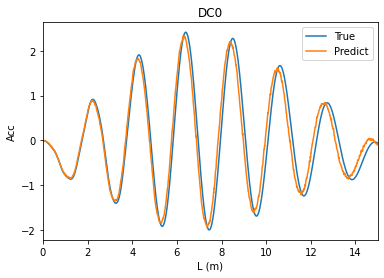

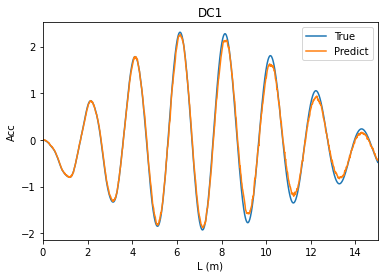

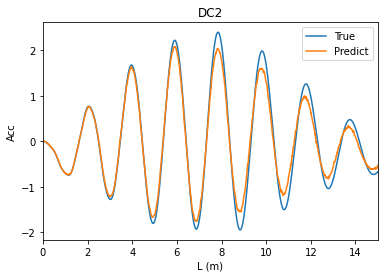

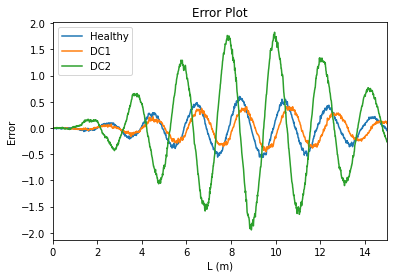

In [62]:
# plotting Training and testing data 
X_Dam_00_Pred=vae.predict(X_Dam_00_map,batch_size=batch_size)
X_Dam_15_Pred=vae.predict(X_Dam_15_map,batch_size=batch_size)
X_Dam_30_Pred=vae.predict(X_Dam_30_map,batch_size=batch_size)



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_00_map[sample,:], label='True')
    plt.plot(dist,X_Dam_00_Pred[sample][:, 0], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC0')
    plt.legend()



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_15_map[sample,:], label='True')
    plt.plot(dist,X_Dam_15_Pred[sample][:, 0], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC1')
    plt.legend()



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_30_map[sample,:], label='True')
    plt.plot(dist,X_Dam_30_Pred[sample][:, 0], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC2')
    plt.legend()

plt.figure()
plt.plot(dist,X_Dam_00_map[2,:]-X_Dam_00_Pred[2,:],label='Healthy')
plt.plot(dist,X_Dam_15_map[2,:]-X_Dam_15_Pred[2,:],label='DC1')
plt.plot(dist,X_Dam_15_map[2,:]-X_Dam_30_Pred[2,:],label='DC2')
plt.xlim(0,15)
plt.xlabel('L (m)')
plt.ylabel('Error')
plt.title('Error Plot')
plt.legend()

**End**